While bowling, this week, an interesting question came up: is it possible to get every score from 1 to 450 in a game of five pin bowling? Or, to flip it around, is there a score that you can never get no matter how fancy your bowling? The answer is not immediately obvious!

## The rules of five pin bowling

[Five pin bowling](https://en.wikipedia.org/wiki/Five-pin_bowling) uses five pins but, unlike ten pin bowling, the pins are worth different amounts. Notably no pin is worth 1, and so a score of *1* is the first impossible score.

::: {#fig-scoring}
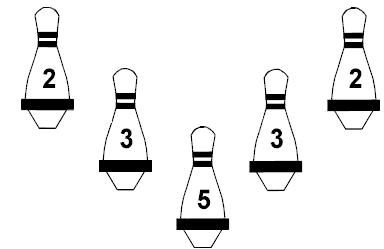

The points value of each pin in five-pin bowling.
:::

Like ten pin bowling, if a strike or a spare is recorded in a given frame then the scores of subsequent ball(s) are counted in that frame, as well as the frame in which they were thrown. So, for example, if I throw a strike in the first frame I don't actually know what to write on the score sheet for the first frame until the second, and possibly third, frames have been thrown. I know it is *at least* 15, but until I throw the next ball it could be anything up to 45. This was what initially gave me pause. It adds a layer of complexity since the possible scores for a given frame depend on what happens next.

By symmetry, though, this way of scoring is equivalent to every strike and spare adding a *multiplier* to the next frame, and each frame is just scored counting whatever the pinfall is and applying the multiplier (no looking backwards). So, if I throw a strike in the first frame, then I record a *15* for the first frame and *double count* the next two balls. If I have thrown two strikes in a row then I *triple count* the first subsequent ball and *double count* the next one. This is a weird way of managing a score sheet, for bowlers, but makes it a lot easier to reason about the possible scores, since you don't have to constantly be looking back two or three frames. This *passing forward* score sheet looks different to a regular one: The maximum score for the first frame is now 15, and for the second frame 30, and in the tenth frame it is possible to score *90* points. On a conventional score sheet the max score in any frame is 45.

## Trying everything

While hanging out at the lanes a few obvious impossible scores got thrown out: a *1*, obviously, but also a *449* -- there's no way to throw a 14 with the last ball in the tenth frame. But the question still lingered: are there any other gaps? It was not immediately obvious, to my bowling team, how you would figure that out without checking.

Maybe we can brute-force this and try every conceivable bowling game? However there are *a lot* of possible bowling games. As a first pass, there are thirty balls thrown in a game and each ball has *up to* fourteen possible pinfall scores (0 through 15 excluding 1 and 14). This would give *14<sup>30</sup>* possible bowling games. Even if it took a single nanosecond to evaluate each game that would take longer than the current age of the universe to work through.

But that's not a great upper bound, it doesn't take into account the rules of bowling: you can only knock down up to five pins in any given frame, for example if the first ball scores a *13* then the second ball doesn't get to choose from fourteen possibilities, it gets to chose from two: 0 and 2. Still, it is going to be a large number. The vast majority of those games are going to be completely redundant, since we are only looking for scores from 2 to 450.

## Nothing fancy

The easiest case to look at is when one never throws a strike or spare. In this case the possible scores for each frame are the same: just what you can get from knocking down any subset of the pins. This happens to be anything from 0 to 15 except *1* and *14*. That's easy enough to see just by inspection.

This also leads to a (kinda loose) argument for why you should be able to get anything from 0 to 150 except *1* and *149*:

Suppose you are playing game with *n* frames and your goal is a score $x \le 15 n$.

If $x \not \equiv 1 (\textrm{mod} 15)$ and $x \not \equiv 14 (\textrm{mod} 15)$ then you can always get from a multiple of 15 to the final score in one frame.

If $x \equiv 1 (\textrm{mod} 15)$ or $x \equiv 14 (\textrm{mod} 15)$ then you can't get from a multiple of 15 to the final score in one frame, this is because you cannot score *1* or *14* in one frame. You can score 1 more than a multiple of 15 if you have two frames remaining: score a *13* in the first and a *2* in the next. Similarly you can score 1 less than a multiple of 15 if you have two frames remaining: score a *7* in the first frame and a *7* in the second.

Since for any *x* such that $1 \lt x \le 15 (n-1)$ there are $\ge 2$ frames remaining, all of those scores can thus be achieved. 

What remains is the *x* such that $15(n-1) \lt x \lt 15 n$ and $x \equiv 14 (\textrm{mod} 15)$, this single score is not achievable in a game with no strikes and spares.

Which is all to say there are only two impossible scores: *1* and *15n -1* or *149* in a standard ten frame game.

I suspect that, if you wanted to put the work in, you could extend this argument to include spares and strikes, with all of the complications around how the 10th frame is scored. But an alternative is to just look through all possible scores and try and find a game that achieves it, using this general approach as a guide.

This is pretty easy to do when only looking at the case where there are no strikes or spares: I generate a list of possible scores for a single frame (a possible move I can take towards my goal), sorted largest to smallest.

In [1]:
basic_moves = [ n for n in range(16) if n not in [1,14] ]
basic_moves.reverse()

Then I define a function that recursively walks through the tree of possible games, always picking the largest viable move at each frame. If it finds an answer it returns it (in reverse order), if it exhausts the possible moves then it returns an empty list.[^1]

[^1]: This code stops once it has found a single valid solution, it could be extended very easily to find *every* valid solution, however the space of possible games is *huge*.

In [2]:
def make_moves(cur_frame, cur_score, max_frame, target, moves=basic_moves):
    if cur_frame == max_frame:
        return [0] if cur_score == target else []
    else:
        next_frame = cur_frame + 1
        mn, mx = min(moves), max(moves)
        n = max_frame - next_frame
        r = target - cur_score
        for move in filter(lambda x: n*mn <= (r-x) <= n*mx, moves):
            new_score = cur_score + move
            advance = make_moves(next_frame, new_score, max_frame, target, moves)
            if len(advance) > 0:
                advance.append(move)
                return advance
        else:
            return []

Looping through all the scores: $0 \le score \le 150$ yields the impossible to bowl scores.

In [3]:
for score in range(151):
    game = make_moves(0,0,10,score)
    if len(game) == 0:
        print("Score {0} is not possible".format(score))


Score 1 is not possible
Score 149 is not possible


Which is what I expected, good news as I will be building off this general strategy for the cases where strikes and spares are included.

### Detour: what about with no gutters?

Another question that comes to mind is: what if you were restricted to always hitting a pin, no gutter balls? Now you can't get a score less than 7 (equivalent to hitting 2-2-3, the lowest pins). Does this change anything?[^2]

[^2]: In five pin it is actually possible to bowl between the pins and hit nothing without it *technically* being a gutter ball, and you can bowl into the blank spots left by pins that were already knocked down to score zeros without putting it in the gutter. I am using the term *gutter ball* loosely.

Probably I could go back and look at the math again, but the nice thing about having written code is that I can just change the space of possible moves and run it again.

In [4]:
no_gutters = [ n for n in range(7,16) if n != 14 ]
no_gutters.reverse()

In [5]:
for score in range(70,151):
    game = make_moves(0,0,10,score,no_gutters)
    if len(game)==0:
        print("Score {0} is not possible, with no gutters".format(score))


Score 149 is not possible, with no gutters


So nothing really changes. I mean you can't get a score *&lt;70*, obviously, but this doesn't open up any *gaps* in possible scores either.

It does mean the strategy changes, now the code takes the biggest strides it can until the remainder is a multiple of 7 then runs out the game with a string of 7s.[^3]

[^3]: You may have noticed an extra "frame" at the end with a score of 0. This is because, in five pin bowling, the last frame has special rules. You always get 3 balls in the last frame, even if your first two are a strike or spare. In this case, with no strikes or spares allowed by design, that extra scoring doesn't enter into it.

In [6]:
[ frame for frame in reversed(make_moves(0,0,10,100,no_gutters)) ]

[15, 15, 15, 13, 7, 7, 7, 7, 7, 7, 0]

## Sparing no effort

Adding in spares means I can't easily track the state of each frame with an integer, like I did for the case with deadwood every frame. Now I need to track three different properties for a given frame:

+ what was scored in the frame
+ whether a strike or a spare was recorded
+ whether this is the end of the last frame (i.e am I done bowling yet?)

Instead of diving into the full set of scoring rules for everything, I'm going to take one baby step forward and add in a data structure to track the state of the frame and select from two sets of possibilities for the subsequent frame: was there a spare or not?

The data structure I'm using is just a struct, tracking the score, whether it is a "special" frame and whether or not it is the end of the game.

In [7]:
class SingleFrame:
    def __init__(self, score, special=None, end=False):
        self.score = score
        self.special = special
        self.end = end

Instead of a list of integers for possible moves, I now need a list of possible `SingleFrame` objects that represent a possible frame, now including the possibility of a spare. Note the *pass forward* approach to scoring: a spare in a regular frame is only worth *15*.

In [8]:
single_frame_moves = [ SingleFrame(score) for score in basic_moves ]
single_frame_moves.insert(0, SingleFrame(15,"spare"))

Now I iterate through the possible first, second, and third balls for a frame *following* a spare. There are more possible scores here since the first ball will be double counted. First I exhaustively generate every combination then use `set()` to extract only the unique elements. For this purpose it doesn't matter how many ways you can get a given score.

In [9]:
spares = [ 2*f+s for f in basic_moves 
                 for s in filter(lambda x: f+x==15,basic_moves)]

spares = list(set(spares))
spares.sort(reverse=True)

non_spares = [ 2*f+s+t for f in basic_moves
                       for s in filter(lambda x: f+x<15, basic_moves)
                       for t in filter(lambda x: f+s+x<=15, basic_moves) ]

non_spares = list(set(non_spares))
non_spares.sort(reverse=True)

Now I generate a list of moves by combining the spares and non-spares. They are arranged such that the code tries the spares first before the non-spares, going from largest to smallest. There are now *42* possible ways of scoring a frame when spares are included (versus only *14* when they aren't).

In [10]:
spare_frame_moves = [ SingleFrame(score,"spare") for score in spares ]
spare_frame_moves += [ SingleFrame(score) for score in non_spares ]

len(spare_frame_moves)

42

There are only two scores that are not achievable in the frame following a spare: *1* and *29*

In [11]:
[ s for s in range(31) if s not in [x.score for x in spare_frame_moves] ]

[1, 29]

Adding spares has also complicated determining if a move is *valid* or not. Since scoring now depends on the state of a given move -- *is it a spare or not* -- this impacts the bounds of possible scores that can follow any given move. Instead of putting this all into the same function, as I did before, I have broken it out into its own function that decides, given a move, a remaining number of frames, and a remaining number of points to pick up, is the move *valid*.[^4]

[^4]: There is an extra move at the end because of the last frame rule: A spare at the start of the last frame leads to an extra ball, but one that can only count for up to 15.

In [12]:
def valid_spare_moves(move, n, r, mn=0, mx=15):
    if move.special=="spare":
        up = (2*n + 1)*mx
    else:
        up = (1 + 2*max(n-1,0) + 1)*mx
    
    return n*mn <= (r - move.score) <= up

The bulk of the main function is the same. The one exception is that it now tracks whether the previous frame was a spare (with `was_spare`) and uses this to determine how to finish the last frame: if the last frame was a spare, then an extra ball is thrown but with no multiplier.

In [13]:
def make_spare_moves(cur_frame, cur_score, max_frame, target, 
                     moves=single_frame_moves, was_spare=False):
    if cur_frame == max_frame:
        if cur_score == target:
            return [SingleFrame(0,False,True)]
        elif was_spare and (target - cur_score) in basic_moves:
            # extra ball in the last frame
            return [SingleFrame(target-cur_score,False,True)]
        else:
            return []
    else:
        next_frame = cur_frame + 1
        n = max_frame - next_frame
        r = target - cur_score
        for move in filter(lambda x: valid_spare_moves(x,n,r), moves):
            new_score = cur_score + move.score
            if move.special == "spare":
                next_moves = spare_frame_moves
            else:
                next_moves = single_frame_moves
            
            advance = make_spare_moves(next_frame, new_score, max_frame, target, next_moves, move.special=="spare")
            if len(advance) > 0:
                advance.append(move)
                return advance
        else:
            return []

Looping through all the scores: $0 \le score \le 300$ yields the impossible to bowl scores, when spares are allowed.

In [14]:
for score in range(301):
    game = make_spare_moves(0,0,10,score)
    if len(game)==0:
        print("Score {0} is not possible, with only spares allowed".format(score))


Score 1 is not possible, with only spares allowed
Score 299 is not possible, with only spares allowed


Which is perhaps not surprising, we still can't get 1 less than the largest multiple of 15 because we cannot bowl a *14* with the extra ball at the end of the 10th frame.

## In striking distance of the final answer

This puts me in a good position to try a full game, I need to add the possibility of a strike. For single frame scores with nothing special before them, this just means adding a third way to score a *15*. There are now 16 possible moves.

In [15]:
# all the different scores for a frame following a regular frame

single_frame_moves = [ SingleFrame(score) for score in basic_moves ]
single_frame_moves.insert(0, SingleFrame(15,"spare"))
single_frame_moves.insert(0, SingleFrame(15,"strike"))

len(single_frame_moves)

16

Similarly the possible ways to follow a spare are the same as before, except that there is no way to "spare" with 30. Scoring a 30 after a spare requires that one throw a strike.

In [16]:
# all the different scores for a frame following a spare

spare_frame_moves = [ move for move in spare_frame_moves if move.score !=30 ]
spare_frame_moves.insert(0, SingleFrame(30,"strike"))

len(spare_frame_moves)

42

Following a single strike the rules are different: the first two balls count twice and the third counts once. Here I exhaustively generate all strikes, spares, and remaining that could follow a single strike and then trim only to the unique scores. This is a much *smaller* set as all spares that follow a strike must, by definition, have a score of 30.

In [17]:
# all the different scores for a frame following a single strike

non_spares = [ 2*f+2*s+t for f in filter(lambda x: x!=15,basic_moves)
                         for s in filter(lambda x: f+x<15, basic_moves)
                         for t in filter(lambda x: f+s+x<=15, basic_moves) ]

non_spares = list(set(non_spares))
non_spares.sort(reverse=True)

single_strike_moves = [ SingleFrame(30,"strike") ]
single_strike_moves += [ SingleFrame(30,"spare") ]
single_strike_moves += [ SingleFrame(score) for score in non_spares ]

len(single_strike_moves)

30

Following a double strike the rules are different again: the first ball is triple counted, the second double counted, and the third single counted.

In [18]:
# all the different scores for a frame following 2 strikes

spares = [ 3*f+2*s for f in filter(lambda x: x!=15,basic_moves)
                   for s in filter(lambda x: f+x==15,basic_moves)]

spares = list(set(spares))
spares.sort(reverse=True)

non_spares = [ 3*f+2*s+t for f in filter(lambda x: x!=15,basic_moves)
                         for s in filter(lambda x: f+x<15, basic_moves)
                         for t in filter(lambda x: f+s+x<=15, basic_moves) ]

non_spares = list(set(non_spares))
non_spares.sort(reverse=True)

double_strike_moves = [ SingleFrame(45,"strike") ]
double_strike_moves += [ SingleFrame(score,"spare") for score in spares ]
double_strike_moves += [ SingleFrame(score) for score in non_spares ]

len(double_strike_moves)

55

This change in scoring, allowing for triple scoring, changes the bounds of possible scores following a given move. Now, after a strike, the next frame could count triple. But there are also potentially *two* more balls in the 10th frame that don't count equally towards the upper bound on the score. The function to check for valid moves needs to be updated to reflect this.

In [19]:
def valid_full_moves(move, n, r, mn=0, mx=15):
    if move.special=="strike":
        # max score is 3 times the max score for the remaining frames
        # plus the multiplier for the remaining balls in the last frame
        up = (3*n + 2 + 1)*mx
    elif move.special=="spare":
        # max score is 2 times the max score for the next frame
        # 3 times the max score for the remaining frames
        # plus the multiplier for the remaining balls in the last frame
        up = (2 + 3*max(n-1,0) + 2 + 1)*mx
    else:
        up = (1 + 2*max(n-1,0) + 2 + 1)*mx
    return n*mn <= r - move.score <= up

At this point all of the sets of moves for a regular frame contain every score except *1* and *1* less than the max score (i.e. a frame following a spare or single strike cannot score a 29 and a frame following a double-strike cannot score a 44). At this point you may expect that the only impossible scores will be *1* and *449* -- this was true with the cases above. *However* there are two more sets of scoring possibilities *just for the last frame*.

If the last frame starts with a spare, then it is the same as before: single ball, no multiplier.

If the last frame starts with a strike, and is not preceded by one, then there are *potentially* two more balls left with no multipliers attached. And these do leave gaps.

In [20]:
# all the different scores for the last 2 balls of the last frame
# assuming the first ball in the last frame was a strike
last_frame_moves = [ f+s for f in basic_moves 
                         for s in filter(lambda x: f+x<=15,basic_moves) ]
last_frame_moves += [ 15 + s for s in basic_moves ]
last_frame_moves = set(last_frame_moves)

[ s for s in range(31) if s not in last_frame_moves ]

[1, 16, 29]

If the last frame starts with a strike *and* is preceded by one, then there are potentially two more balls but the first one is double counted. Again, this leaves gaps.

In [21]:
# all the different scores for the last 2 balls of the last frame
# assuming the second to last frame was a strike and the first ball
# in the last frame was a strike
last_frame_double_moves = [ 2*f+s for f in basic_moves
                           for s in filter(lambda x: f+x<=15,basic_moves) ] 
last_frame_double_moves += [ 30 + s for s in basic_moves ]
last_frame_double_moves = set(last_frame_double_moves)

[ s for s in range(46) if s not in last_frame_double_moves ]

[1, 29, 31, 44]

It certainly looks now like there will be at least 4 scores that can't be achieved because there no way to make the last step with the extra balls in the 10th frame, because the 10th frame is scored differently. This additional scoring complexity now makes it unwieldy to put all of that into the main function. I have broken it out into a separate function that just checks the last frame and either returns the last move with the remaining balls or returns an empty list if there is no possible move.

In [22]:
def last_frame_rule(remaining, last_frame, max_move, mx=45):
    if remaining == 0:
        # hit the target, don't need any additional balls
        return [SingleFrame(0,None,True)]
    elif last_frame == "strike" and max_move == mx and remaining in last_frame_double_moves:
        # two extra balls following a double strike
        return [SingleFrame(remaining,None,True)]
    elif last_frame == "strike" and remaining in last_frame_moves:
        # two extra balls following a single strike
        return [SingleFrame(remaining,None,True)]
    elif last_frame == "spare" and remaining in basic_moves:
        # only one extra ball
        return [SingleFrame(remaining,None,True)]
    else:
        # not possible
        return []

The main function now has to track whether the last frame was a strike, to trigger the double strike rules, versus single strikes, spares, and regular frames. The logic is the same, though.

In [23]:
def make_full_moves(cur_frame, cur_score, max_frame, target, 
                     moves=single_frame_moves, last_frame=None):
    if cur_frame == max_frame:
        # max_move is used to check if the second-to-last frame was a strike
        max_move = max( s.score for s in moves )
        return last_frame_rule(target-cur_score, last_frame, max_move)
    else:
        next_frame = cur_frame + 1
        n = max_frame - next_frame
        r = target - cur_score
        for move in filter(lambda x: valid_full_moves(x,n,r), moves):
            new_score = cur_score + move.score
            if last_frame == "strike" and move.special == "strike":
                next_moves = double_strike_moves
                next_last_frame = "strike"
            elif move.special == "strike":
                next_moves = single_strike_moves
                next_last_frame = "strike"
            elif move.special == "spare":
                next_moves = spare_frame_moves
                next_last_frame = "spare"
            else:
                next_moves = single_frame_moves
                next_last_frame = None

            advance = make_full_moves(next_frame, new_score, max_frame, target, next_moves, next_last_frame)
            if len(advance) > 0:
                advance.append(move)
                return advance
        else:
            return []

Looping through all the scores: $0 \le score \le 450$ yields the impossible to bowl scores, when spares and strikes are allowed.

In [24]:
for score in range(451):
    game = make_full_moves(0,0,10,score)
    if len(game)==0:
        print("Score {} is not possible, full game".format(score))

Score 1 is not possible, full game
Score 434 is not possible, full game
Score 436 is not possible, full game
Score 449 is not possible, full game


This conforms with our intuition, after looking at the possible last-frame moves. Of course this is entirely academic as, the way I bowl, I am in no danger of coming close to these impossible scores.